In [1]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pprint


In [2]:
# Initialize the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).to('mps')

In [3]:
sentence_a = "I flew from New York to Los Angeles using American Airlines and then I will fly to Asia via Europe using Lufthansa."
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True).to('mps')

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)



In [4]:
outputs = model(**inputs)
attention = outputs.attentions
hidden_states = outputs.hidden_states

### Tokens and respective ID's


In [5]:
input_tokens_list = tokenizer.convert_ids_to_tokens(input_id_list)
input_id_list = input_ids[0].tolist() 
res = "\n".join("{} \t {}".format(x, y) for x, y in zip(input_id_list, input_tokens_list))

print(res)
#CLS = Classify token
#SEP = Seperator token

101 	 [CLS]
1045 	 i
5520 	 flew
2013 	 from
2047 	 new
2259 	 york
2000 	 to
3050 	 los
3349 	 angeles
2478 	 using
2137 	 american
7608 	 airlines
1998 	 and
2059 	 then
1045 	 i
2097 	 will
4875 	 fly
2000 	 to
4021 	 asia
3081 	 via
2885 	 europe
2478 	 using
11320 	 lu
6199 	 ##ft
4819 	 ##han
3736 	 ##sa
1012 	 .
102 	 [SEP]


## Contextual embeddings

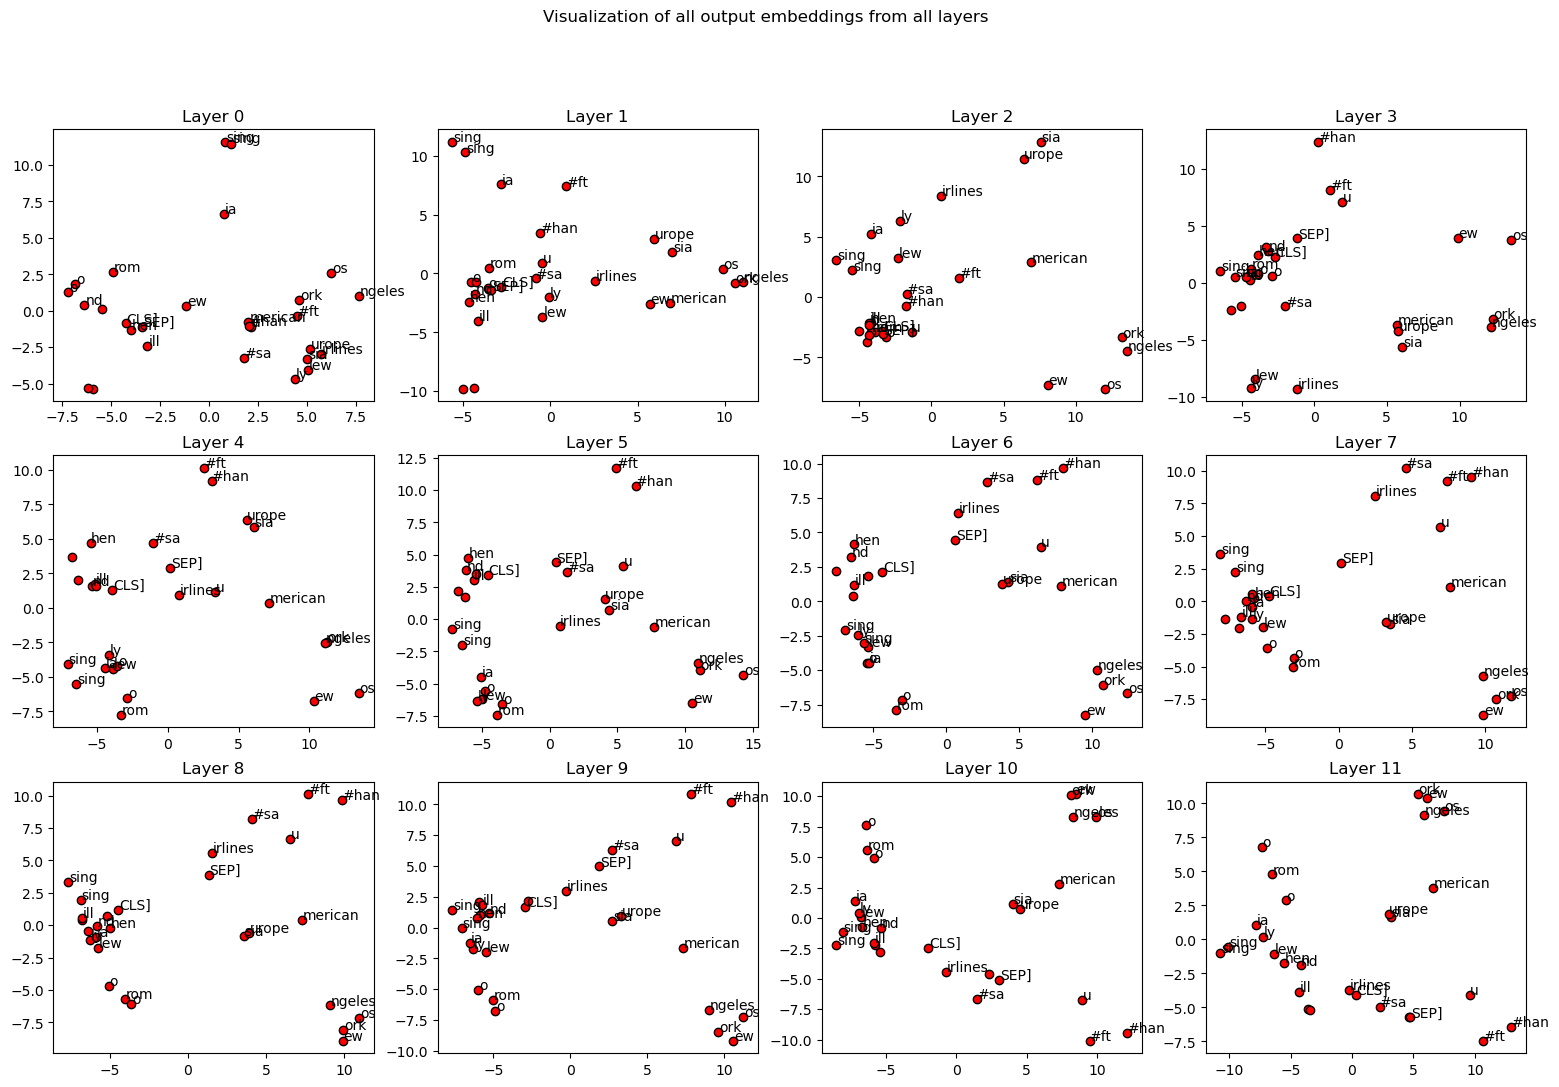

In [6]:

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().cpu().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word[1:])
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

## Positional embeddings


In [7]:
sentence_b = "The rhythmic beat of the drum echoed through the dense jungle, each thump resonating with the primal energy of the wild, stirring the creatures of the forest to the beat of the drum, their senses attuned to the beat, the beat, the beat, as if it were the heartbeat of the earth itself."
sentence_c = "bacalhau " * 20
#Try just b, just c, and then both
inputs = tokenizer.encode_plus(sentence_b, sentence_c, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True).to('mps')

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() 

outputs = model(**inputs)
attention = outputs.attentions
hidden_states = outputs.hidden_states
input_tokens_list = tokenizer.convert_ids_to_tokens(input_id_list)


In [8]:
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

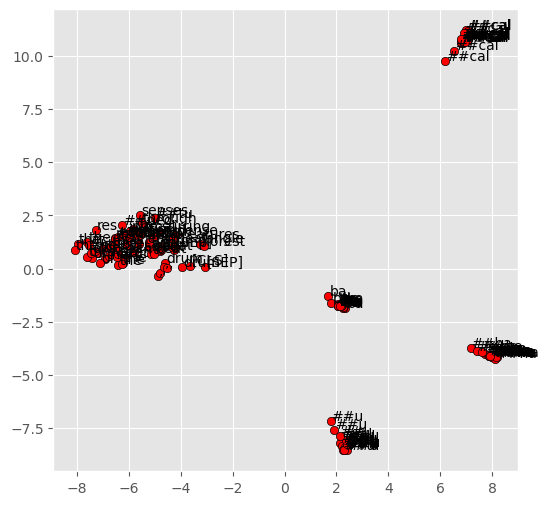

In [9]:

output_embeddings = outputs['last_hidden_state']

display_scatterplot(output_embeddings[0].detach().cpu().numpy(), input_tokens_list)

## Sentence embeddings

## SelfAttention